In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from shallow_fbcsp import ShallowFBCSPNet
import pandas as pd
from collections import OrderedDict
import math
from scipy import signal
import tensorflow as tf

In [2]:
import torch

print(torch.cuda.is_available())


False


In [3]:
def linear_kernel(X):
    """Computes the linear kernel matrix for X."""
    return torch.matmul(X,X.T)  # Dot product

def centering_matrix(K):
    """Apply centering to the kernel matrix."""
    n = K.shape[0]
    H = torch.eye(n) - (1.0 / n) * torch.ones((n, n), device=K.device)
    return H @ K @ H  # Centered kernel matrix

def compute_hsic(K_x, K_y):
    """
    Computes the Hilbert-Schmidt Independence Criterion (HSIC).
    
    Parameters:
    - X: (n_samples, n_features_X) numpy array
    - Y: (n_samples, n_features_Y) numpy array
    - kernel_X: function to compute the kernel matrix for X
    - kernel_Y: function to compute the kernel matrix for Y
    
    Returns:
    - HSIC value (float)
    """
    K_x_centered = centering_matrix(K_x)
    K_y_centered = centering_matrix(K_y)
    hsic_value = np.trace(K_x_centered @ K_y_centered) / ((K_x.shape[0] - 1) ** 2)
    return hsic_value
  
def compute_CKA(K_x,K_y):
  """
  compute CKA between two X,Y activations
  
  Parameters:
  - X: (n_samples, x_features)
  - Y: (n_samples, y_features)
  - kernel_X: kernel for X
  - kernel_Y: kernel for Y  
  """
  HSIC_KL = compute_hsic(K_x,K_y) 
  HSIC_KK = compute_hsic(K_x,K_x)
  HSIC_LL = compute_hsic(K_y,K_y)
  numerator = HSIC_KL
  denominator = math.sqrt(HSIC_KK * HSIC_LL)
  return(numerator/denominator).item()


In [4]:
# Define model parameters
in_chans = 22
n_classes = 4
n_channels = 22
input_window_samples = 1000
# Load two models for comparison
model= torch.load("Shallow/Shallow_model_1.pth",weights_only = False,map_location=torch.device('cpu'))
model2 =ShallowFBCSPNet(in_chans, n_classes, input_window_samples)



In [5]:
print(model)

ShallowFBCSPNet(
  (temporal): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
  (spatial): Conv2d(40, 40, kernel_size=(22, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=(1, 200), stride=(1, 200), padding=0)
  (batch_norm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=4, bias=True)
)


In [6]:
import pickle
with open('Datasets/test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [7]:
#print(model.conv_time.weight.device)  # Check the device of the conv_time layer
#print(next(model.parameters()).device)


In [8]:
X = torch.stack([torch.from_numpy(test_set[i][0]) for i in range(len(test_set))])
X = signal.resample(X.numpy(), 1000)
X = torch.tensor(X)
total_samples = X.shape[0]
print(X.shape)  # Verify the tensor shape
print(type(X))  # Should output <class 'torch.Tensor'>

torch.Size([1000, 22, 1125])
<class 'torch.Tensor'>


In [ ]:
import torch
from scipy import signal

# Assuming test_set is already loaded
X = torch.stack([torch.from_numpy(test_set[i][0]) for i in range(len(test_set))])

# Resample each sample along the time axis (dim=2)
resampled_X = []
for i in range(X.shape[0]):  # Loop over the number of samples (1000)
    sample = X[i].numpy()  # Convert to NumPy for resampling
    resampled_sample = signal.resample(sample, 1000, axis=-1)  # Resample to 1000 time points
    resampled_X.append(torch.tensor(resampled_sample))  # Convert back to torch tensor

# Stack the resampled samples back into a tensor
X_resampled = torch.stack(resampled_X)

print(X_resampled.shape)  # Should be [1000, 22, 1000]


In [9]:
import os
import torch
from collections import OrderedDict

def extract_model_activations(model, input_tensor, output_dir, batch_size=128, device='cuda'):
    # Make sure the model is on the correct device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
        
    # Make sure the input tensor is also on the same device
    input_tensor = input_tensor.to(device)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    activations = OrderedDict()

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks for specific layers
    for name, layer in model.named_modules():
        if name == "temporal" or name == "spatial" or name == "pool" or name == "dropout" or name == "batch_norm" or name == "dropout" or name == "fc":  # Modify as per your layer names
            layer.register_forward_hook(get_activation(name))
        if "weight" in name: 
            print(f"{name} weight shape: {param.shape}")

    model.eval()

    with torch.no_grad():
        for i in range(0, input_tensor.shape[0], batch_size):
            batch = input_tensor[i:i + batch_size]  # Select current batch
            batch = batch.to(device)  # Make sure the batch is on the correct device
            
            # Forward pass through the model
            _ = model(batch)  

            # Save activations after each batch
            for name, activation in activations.items():
                batch_idx = i // batch_size + 1  # This determines the batch number
                print(f"saving: {name}_batch_{batch_idx}.pt")
                torch.save(activation, os.path.join(output_dir, f"{name}_batch_{batch_idx}.pt"))
            
            # Clear activations list after saving
            activations.clear()
            torch.cuda.empty_cache()  # Optional: Clear GPU memory after each batch


# Call the function with the correct device:
# Assuming 'model' is your model and 'X' is the input tensor
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_model_activations(model, X.T, output_dir="Datasets/Shallow_activations/model1/", batch_size=1125, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_844\838504088.py:54: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  extract_model_activations(model, X.T, output_dir="Datasets/Shallow_activations/model1/", batch_size=1125, device=device)


saving: temporal_batch_1.pt
saving: spatial_batch_1.pt
saving: batch_norm_batch_1.pt
saving: pool_batch_1.pt
saving: dropout_batch_1.pt
saving: fc_batch_1.pt


torch.Size([2592, 22, 1000])


In [11]:
#print(model.conv_time.weight.device)  # Check the device of the conv_time layer
#print(next(model.parameters()).device)


In [12]:
#extract_model_activations(model,X,output_dir="Datasets/activations/model1/",batch_size=batch_size)


In [37]:
#extract_model_activations(model2,X,output_dir="Datasets/activations/model4/",batch_size=batch_size)

In [13]:
#length = torch.load(f"Datasets/activations/model1/conv_time_batch_{3}.pt")
#print(length.shape)

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
del X
# Use OrderedDict to preserve the order of layer names
layer_names_model1 = ["spatial","pool","dropout","batch_norm", "dropout","fc"]
layer_names_model2 = layer_names_model1


print(layer_names_model1)
print(layer_names_model2)

['spatial', 'pool', 'dropout', 'batch_norm', 'dropout', 'fc']
['spatial', 'pool', 'dropout', 'batch_norm', 'dropout', 'fc']


In [15]:
import math
batch_nr = total_samples /batch_size

#batch_nr

NameError: name 'batch_size' is not defined

In [ ]:




def compute_kernel_full_highmem(layer, batch_nr, model_number):
    """Computes the linear kernel for all samples at once."""
    

    activations_list = []
    
    for batch_idx in range(1, math.ceil(batch_nr+1)):
        print(f"\rLoading batch {batch_idx} for {layer} in model {model_number}", end='', flush=True)
        

        batch_activations = torch.load(f"Datasets/activations/model{model_number}/{layer}_batch_{batch_idx}.pt")
        batch_activations = batch_activations.reshape(batch_activations.shape[0], -1)  # Flatten
        
        activations_list.append(batch_activations)
    
    all_activations = torch.cat(activations_list, dim=0)
    print("\nFinal Activations Shape:", all_activations.shape)

    full_kernel = torch.matmul(all_activations, all_activations.T)

    return full_kernel

# model_1_kernels = OrderedDict()
# model_2_kernels = OrderedDict()

# for layer in layer_names_model1:
#     model_1_kernels[layer] = compute_kernel_full_highmem(layer, batch_nr,1)
# for layer in layer_names_model2:
#     model_2_kernels[layer] = compute_kernel_full_highmem(layer,batch_nr,2)







In [ ]:
#model1= torch.load("Collapsed_Shallow/braindecode_model_temponly_1.pth",weights_only = False,map_location=torch.device('cpu'))
#model2= torch.load("Collapsed_Shallow/braindecode_model_temponly_2.pth",weights_only = False,map_location=torch.device('cpu'))


In [17]:

def compute_kernel_full_lowmem_shallow(layer, batch_nr, model_number, total_samples, batch_size, n_batches=1, use_cuda=False):
    """Computes the full kernel matrix in batches efficiently using matrix multiplication."""
    
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

    full_kernel = torch.zeros((total_samples, total_samples), dtype=torch.float32, device=device)
    
    for batch_idx in range(1, math.ceil(math.ceil(batch_nr) / n_batches) + 1):
        print(f"\rLoading batches {batch_idx * n_batches - (n_batches - 1)}-{batch_idx * n_batches} for {layer} in model {model_number}", 
              end='', flush=True)

        batch_activations_list = []
        start_idx_col = (batch_idx - 1) * batch_size * n_batches
        end_idx_col = min(start_idx_col + batch_size * n_batches, total_samples)  

        # Load multiple batches at once
        for sub_batch in range(n_batches):
            batch_file_idx = (batch_idx - 1) * n_batches + sub_batch + 1
            if batch_file_idx > math.ceil(batch_nr):
                break
            batch_activations = torch.load(
                f"Datasets/Shallow_activations/model{model_number}/{layer}_batch_{batch_file_idx}.pt"
            ).to(device)
            batch_activations_list.append(batch_activations.reshape(batch_activations.shape[0], -1))

        if not batch_activations_list:
            continue

        batch_activations = torch.cat(batch_activations_list, dim=0)  # Merge batches

        for batch_idx2 in range(1, math.ceil(math.ceil(batch_nr) / n_batches) + 2):
            batch_activations_transpose_list = []
            start_idx_row = (batch_idx2 - 1) * batch_size * n_batches
            end_idx_row = min(start_idx_row + batch_size * n_batches, total_samples)

            # Load multiple batches at once
            for sub_batch2 in range(n_batches):
                batch_file_idx2 = (batch_idx2 - 1) * n_batches + sub_batch2 + 1
                if batch_file_idx2 > math.ceil(batch_nr):
                    break
                batch_activations_transpose = torch.load(
                    f"Datasets/Shallow_activations/model{model_number}/{layer}_batch_{batch_file_idx2}.pt").to(device)
                batch_activations_transpose_list.append(batch_activations_transpose.reshape(batch_activations_transpose.shape[0], -1))

            if not batch_activations_transpose_list:
                continue

            batch_activations_transpose = torch.cat(batch_activations_transpose_list, dim=0)
            print(print(batch_activations.shape, batch_activations_transpose.shape))
            kernel_block = batch_activations @ batch_activations_transpose.T
            full_kernel[start_idx_col:end_idx_col, start_idx_row:end_idx_row] = kernel_block
            full_kernel[start_idx_row:end_idx_row, start_idx_col:end_idx_col] = kernel_block.T  # Use symmetry
            #print(f"full_kernel slice shape: [{start_idx_col}:{end_idx_col}, {start_idx_row}:{end_idx_row}]")
            #print(f"Expected shape: [{end_idx_col - start_idx_col}, {end_idx_row - start_idx_row}]")
            #print(f"kernel_block shape: {kernel_block.shape}")


    return full_kernel.cpu()


def compute_full_kernels_shallow(layer_names_model1,model_number, layer_names_model2, batch_nr, total_samples,batch_size,n_batches):
    """Computes the kernels for both models."""
    model_1_kernels = {}
    model_2_kernels = {}

    # Compute kernels for model 1
    for layer in layer_names_model1:
        model_1_kernels[layer] = compute_kernel_full_lowmem_shallow(layer, batch_nr, model_number, total_samples,batch_size,n_batches)

    # Compute kernels for model 2
    #for layer in layer_names_model1:
    #    model_2_kernels[layer] = compute_kernel_full_lowmem(layer, batch_nr, 1, total_samples,batch_size,n_batches)

    return model_1_kernels

model_1_kernels = OrderedDict()
#model_2_kernels = OrderedDict()
layer_names_model = layer_names_model1 

batch_size = 1125
### Takes 51 Min and 15 sec. Shallow
### Takes 3 Min and 25 sec with Collapsed Shallow
### Takes      
model_1_kernels = compute_full_kernels_shallow(layer_names_model,1, layer_names_model, 1,total_samples,batch_size,2)
model_2_kernels = compute_full_kernels_shallow(layer_names_model,2, layer_names_model, 9,total_samples,batch_size,2)
model_3_kernels = compute_full_kernels_shallow(layer_names_model,3, layer_names_model, 9,total_samples,batch_size,2)
model_4_kernels = compute_full_kernels_shallow(layer_names_model,4, layer_names_model, 9,total_samples,batch_size,2)
model_5_kernels = compute_full_kernels_shallow(layer_names_model,5, layer_names_model, 9,total_samples,batch_size,2)
model_6_kernels = compute_full_kernels_shallow(layer_names_model,6, layer_names_model, 9,total_samples,batch_size,2)
model_7_kernels = compute_full_kernels_shallow(layer_names_model,7, layer_names_model, 9,total_samples,batch_size,2)
model_8_kernels = compute_full_kernels_shallow(layer_names_model,8, layer_names_model, 9,total_samples,batch_size,2)
model_9_kernels = compute_full_kernels_shallow(layer_names_model,9, layer_names_model, 9,total_samples,batch_size,2)
model_10_kernels = compute_full_kernels_shallow(layer_names_model,10, layer_names_model, 9,total_samples,batch_size,2)


Loading batches 1-2 for spatial in model 1torch.Size([1125, 39040]) torch.Size([1125, 39040])
None


RuntimeError: The expanded size of the tensor (1000) must match the existing size (1125) at non-singleton dimension 1.  Target sizes: [1000, 1000].  Tensor sizes: [1125, 1125]

In [51]:
import torch
import math

def compute_kernel_full_lowmem_conformer(layer, batch_nr, model_number, total_samples, batch_size, n_batches=1, use_cuda=False):
    """Computes the full kernel matrix efficiently using matrix multiplication in low memory."""

    # Select the device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
    
    # Initialize the full kernel matrix with zeros
    full_kernel = torch.zeros((total_samples, total_samples), dtype=torch.float32, device=device)

    # Loop through batches to load the activations and compute the kernel matrix
    for batch_idx in range(1, math.ceil(batch_nr / n_batches) + 1):
        print(f"\rLoading batches {batch_idx * n_batches - (n_batches - 1)}-{batch_idx * n_batches} for {layer} in model {model_number}",
              end='', flush=True)

        batch_activations_list = []
        start_idx_col = (batch_idx - 1) * batch_size * n_batches
        end_idx_col = min(start_idx_col + batch_size * n_batches, total_samples)

        # Load multiple batches at once
        for sub_batch in range(n_batches):
            batch_file_idx = (batch_idx - 1) * n_batches + sub_batch + 1
            if batch_file_idx > math.ceil(batch_nr):
                break
            # Corrected file path, replace the layer name and model number properly
            batch_activations = torch.load(
                f"Datasets/Conformer_activations/model{model_number}/{layer}_batch_{batch_file_idx}.pt"
            ).to(device)
            batch_activations_list.append(batch_activations.reshape(batch_activations.shape[0], -1))

        if not batch_activations_list:
            continue

        # Concatenate all batch activations
        batch_activations = torch.cat(batch_activations_list, dim=0)  # Merge batches

        # Ensure correct shape for activations
        assert batch_activations.shape[0] == end_idx_col - start_idx_col, \
            f"Shape mismatch in batch activations: {batch_activations.shape[0]} != {end_idx_col - start_idx_col}"

        # Loop through rows and compute the kernel matrix blocks
        for batch_idx2 in range(1, math.ceil(batch_nr / n_batches) + 2):
            batch_activations_transpose_list = []
            start_idx_row = (batch_idx2 - 1) * batch_size * n_batches
            end_idx_row = min(start_idx_row + batch_size * n_batches, total_samples)

            # Load multiple batches for transposed activations
            for sub_batch2 in range(n_batches):
                batch_file_idx2 = (batch_idx2 - 1) * n_batches + sub_batch2 + 1
                if batch_file_idx2 > math.ceil(batch_nr):
                    break
                # Corrected file path, replace the layer name and model number properly
                batch_activations_transpose = torch.load(
                    f"Datasets/Conformer_activations/model{model_number}/{layer}_batch_{batch_file_idx2}.pt").to(device)
                batch_activations_transpose_list.append(batch_activations_transpose.reshape(batch_activations_transpose.shape[0], -1))

            if not batch_activations_transpose_list:
                continue

            # Concatenate all batch transposed activations
            batch_activations_transpose = torch.cat(batch_activations_transpose_list, dim=0)

            # Ensure correct shape for transposed activations
            assert batch_activations_transpose.shape[0] == end_idx_row - start_idx_row, \
                f"Shape mismatch in transposed activations: {batch_activations_transpose.shape[0]} != {end_idx_row - start_idx_row}"

            # Compute the kernel block by multiplying the activations and their transpose
            kernel_block = batch_activations @ batch_activations_transpose.T

            # Compute the kernel block shape to match the target
            kernel_block = kernel_block[:end_idx_row - start_idx_row, :end_idx_col - start_idx_col]

            # Store the kernel block in the appropriate positions in the full kernel matrix
            full_kernel[start_idx_col:end_idx_col, start_idx_row:end_idx_row] = kernel_block
            full_kernel[start_idx_row:end_idx_row, start_idx_col:end_idx_col] = kernel_block.T  # Ensure symmetry

    # Return the final kernel matrix on the CPU (after computation)
    return full_kernel.cpu()

# Example for computing kernels for multiple models
def compute_full_kernels_conformer(layer_names_model, model_number, batch_nr, total_samples, batch_size, n_batches):
    model_kernels = {}
    print(batch_nr, model_number, total_samples, batch_size, n_batches)
    for layer in layer_names_model:
        model_kernels[layer] = compute_kernel_full_lowmem_conformer(
            layer, batch_nr, model_number, total_samples, batch_size, n_batches, use_cuda=True
        )
    return model_kernels

# Now, let's compute the kernels for models 1 to 10
model_1_kernels = compute_full_kernels_conformer(layer_names_model, 1, batch_nr, total_samples, batch_size, 2)
# Repeat for other models (model_2_kernels, model_3_kernels, etc.)


# Now, let's compute the kernels for models 1 to 10

#model_1_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 1, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_2_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 2, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_3_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 3, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_4_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 4, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_5_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 5, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_6_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 6, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_7_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 7, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_8_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 8, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_9_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 9, layer_names_model, batch_nr, total_samples, batch_size, 2)
#model_10_kernels = compute_kernel_full_lowmem_conformer(layer_names_model, 10, layer_names_model, batch_nr, total_samples, batch_size, 2)



7.8125 1 1000 128 2
Loading batches 1-2 for spatial in model 1

AssertionError: Shape mismatch in transposed activations: 256 != 232

In [21]:

#model_1_kernels = OrderedDict()
#model_2_kernels = OrderedDict()
layer_names_model = layer_names_model1 

### Takes 51 Min and 15 sec. Shallow
### Takes 3 Min and 25 sec with Collapsed Shallow
### Takes      
model_1_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,1, layer_names_model, batch_nr,total_samples,batch_size,2)
model_2_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,2, layer_names_model, batch_nr,total_samples,batch_size,2)
model_3_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,3, layer_names_model, batch_nr,total_samples,batch_size,2)
model_4_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,4, layer_names_model, batch_nr,total_samples,batch_size,2)
model_5_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,5, layer_names_model, batch_nr,total_samples,batch_size,2)
model_6_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,6, layer_names_model, batch_nr,total_samples,batch_size,2)
model_7_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,7, layer_names_model, batch_nr,total_samples,batch_size,2)
model_8_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,8, layer_names_model, batch_nr,total_samples,batch_size,2)
model_9_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,9, layer_names_model, batch_nr,total_samples,batch_size,2)
model_10_kernels = compute_kernel_full_lowmem_conformer(layer_names_model,10, layer_names_model, batch_nr,total_samples,batch_size,2)

NameError: name 'compute_kernel_full_lowmem_conformer' is not defined

In [24]:
from collections import OrderedDict
from concurrent.futures import ThreadPoolExecutor

kernel_list = [model_1_kernels, model_2_kernels, model_3_kernels, model_4_kernels,
               model_5_kernels, model_6_kernels, model_7_kernels, model_8_kernels,
               model_9_kernels, model_10_kernels]

cka_results = OrderedDict()

def compute_cka_pair(layer1, K_x, layer2, K_y):
    cka_value = compute_CKA(K_x, K_y)
    return (layer1, layer2), cka_value

# Parallel computation
with ThreadPoolExecutor() as executor:
    futures = []
    for i, kernel_1 in enumerate(kernel_list):
        print("Kernel so far: ", i)
        for j, kernel_2 in enumerate(kernel_list[i+1:], start=i+1):  # Avoid repeated pairs
            for layer1, K_x in kernel_1.items():
                for layer2, K_y in kernel_2.items():
                    futures.append(executor.submit(compute_cka_pair, layer1, K_x, layer2, K_y))

    for i, future in enumerate(futures):
        print(i)
        pair, cka_value = future.result()
        cka_results[pair] = cka_value
        print(f"CKA{pair}: {cka_value}")


Kernel so far:  0
Kernel so far:  1
Kernel so far:  2
Kernel so far:  3
Kernel so far:  4
Kernel so far:  5
Kernel so far:  6
Kernel so far:  7
Kernel so far:  8
Kernel so far:  9
0
CKA('spatio_temporal', 'spatio_temporal'): 0.9577751450461506
1
CKA('spatio_temporal', 'pool'): 0.09200776530371468
2
CKA('spatio_temporal', 'dropout'): 0.09200776530371468
3
CKA('spatio_temporal', 'batch_norm'): 0.8998336166596254
4
CKA('pool', 'spatio_temporal'): 0.09362888506528227
5
CKA('pool', 'pool'): 0.9630113502600708
6
CKA('pool', 'dropout'): 0.9630113502600708
7
CKA('pool', 'batch_norm'): 0.23843014691919598
8
CKA('dropout', 'spatio_temporal'): 0.09362888506528227
9
CKA('dropout', 'pool'): 0.9630113502600708
10
CKA('dropout', 'dropout'): 0.9630113502600708
11
CKA('dropout', 'batch_norm'): 0.23843014691919598
12
CKA('batch_norm', 'spatio_temporal'): 0.944752016193784
13
CKA('batch_norm', 'pool'): 0.25041350201115536
14
CKA('batch_norm', 'dropout'): 0.25041350201115536
15
CKA('batch_norm', 'batch_no

In [26]:
futures

[<Future at 0x118ad5744c0 state=finished returned tuple>,
 <Future at 0x11889903430 state=finished returned tuple>,
 <Future at 0x1194bec8d60 state=finished returned tuple>,
 <Future at 0x1194be98c70 state=finished returned tuple>,
 <Future at 0x1194beaa3b0 state=finished returned tuple>,
 <Future at 0x1194bebbdc0 state=finished returned tuple>,
 <Future at 0x1194beb8b80 state=finished returned tuple>,
 <Future at 0x1194bedd7e0 state=finished returned tuple>,
 <Future at 0x11891729bd0 state=finished returned tuple>,
 <Future at 0x1194bf0d0f0 state=finished returned tuple>,
 <Future at 0x118c6e10a30 state=finished returned tuple>,
 <Future at 0x118916a9b70 state=finished returned tuple>,
 <Future at 0x118916abfa0 state=finished returned tuple>,
 <Future at 0x118916ab010 state=finished returned tuple>,
 <Future at 0x118916aa380 state=finished returned tuple>,
 <Future at 0x118916a9d20 state=finished returned tuple>,
 <Future at 0x118916a9390 state=finished returned tuple>,
 <Future at 0x

In [ ]:
#futures

[<Future at 0x1becc024610 state=finished returned tuple>,
 <Future at 0x1becc024ac0 state=finished returned tuple>,
 <Future at 0x1becc041570 state=finished returned tuple>,
 <Future at 0x1becc0406a0 state=finished returned tuple>,
 <Future at 0x1becc052230 state=finished returned tuple>,
 <Future at 0x1becc07a3e0 state=finished returned tuple>,
 <Future at 0x1be09eff2b0 state=finished returned tuple>,
 <Future at 0x1be09eff910 state=finished returned tuple>,
 <Future at 0x1be547b0610 state=finished returned tuple>,
 <Future at 0x1be6f280550 state=finished returned tuple>,
 <Future at 0x1becc0aa680 state=finished returned tuple>,
 <Future at 0x1becc031c00 state=finished returned tuple>,
 <Future at 0x1be5472e830 state=finished returned tuple>,
 <Future at 0x1be5472e800 state=finished returned tuple>,
 <Future at 0x1be5472fb50 state=finished returned tuple>,
 <Future at 0x1be5472dc00 state=finished returned tuple>,
 <Future at 0x1be5472f520 state=finished returned tuple>,
 <Future at 0x

In [28]:
results = [future.result() for future in futures]

# Assuming the result of each future is a tuple (pair, cka_value), where:
# - pair is a tuple (Layer1, Layer2)
# - cka_value is the CKA value associated with that pair

# Create the DataFrame
df = pd.DataFrame([(pair[0], pair[1], cka_value) for pair, cka_value in results],
                  columns=['Layer1', 'Layer2', 'CKA_Value'])

df.to_csv("CKA_Collapsed_Shallow.csv", sep ="\t", index = False, header = True)

NameError: name 'df' is not defined

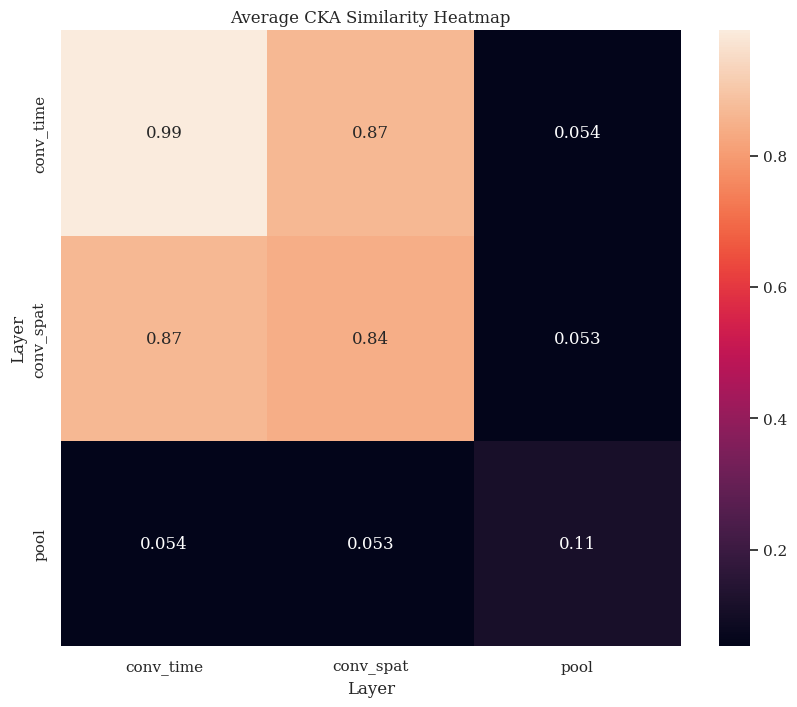

In [ ]:

n_layers = len(layer_names_model1)# + len(layer_names_model2)
matrix = np.zeros((n_layers, n_layers))


for (layer1, layer2), similarity in cka_results.items():
    i = layer_names_model1.index(layer1) if layer1 in layer_names_model1 else len(layer_names_model1) + layer_names_model2.index(layer1)
    j = layer_names_model2.index(layer2) if layer2 in layer_names_model2 else len(layer_names_model2) + layer_names_model1.index(layer2)
    
    matrix[i, j] = similarity
    matrix[j, i] = similarity  # Symmetric matrix
layer_names = ["conv_time","conv_spat", "pool"]
df = pd.DataFrame(matrix, index=layer_names, columns=layer_names)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True)#, cmap='magma', fmt='.2f', square=True)#, linewidths=0.5, cbar=True, vmin=0, vmax=1, xticklabels=layer_names, yticklabels=layer_names)

plt.title('Average CKA Similarity Heatmap')
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.show()

In [ ]:
#!pip install seaborn --upgrade

In [ ]:
#print(df_new)